# Churned Customer Study Notebook

## Objectives

*   Answer business requirement 1: 
    * The client is interested to understand the patterns from the customer base, so the client can learn the most relevant variables that are correlated to a churned customer.

## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv

## Outputs

* generate code that answers business requirement 1 and can be used to build the Streamlit App






---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/churnometer'

---

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv")
    .drop(['customerID'], axis=1)
    )
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1


# Data Exploration

We are interested to get more familiar with the dataset, check variable type and distribution, missing levels and what these variables mean in a business context

In [6]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.0/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.0/u/import-error

# Correlation Study

In [5]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
print(df_ohe.shape)
df_ohe.head(3)

(7043, 46)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_Yes,Partner_No,Dependents_No,...,StreamingMovies_No internet service,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaperlessBilling_No,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic)
0,0,1,29.85,29.85,0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
1,0,34,56.95,1889.50,0,0,1,0,1,1,...,0,0,1,0,0,1,0,1,0,0
2,0,2,53.85,108.15,1,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,0


We use `.corr()` for `spearman` and `pearson` methods, and investigate the top 10 correlations
* We know this command returns a pandas series and the first item is the correlation between Churn and Churn, which happens to be 1, so we exclude that with `[1:]`
* We sort values considering the absolute value, by setting `key=abs`

In [6]:
corr_spearman = df_ohe.corr(method='spearman')['Churn'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

Contract_Month-to-month           0.405103
tenure                           -0.367062
OnlineSecurity_No                 0.342637
TechSupport_No                    0.337281
InternetService_Fiber optic       0.308020
Contract_Two year                -0.302253
PaymentMethod_Electronic check    0.301919
OnlineBackup_No                   0.268005
DeviceProtection_No               0.252481
TotalCharges                     -0.232190
Name: Churn, dtype: float64

We do the same for `pearson`

In [7]:
corr_pearson = df_ohe.corr(method='pearson')['Churn'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

Contract_Month-to-month                 0.405103
tenure                                 -0.352229
OnlineSecurity_No                       0.342637
TechSupport_No                          0.337281
InternetService_Fiber optic             0.308020
Contract_Two year                      -0.302253
PaymentMethod_Electronic check          0.301919
OnlineBackup_No                         0.268005
DeviceProtection_No                     0.252481
DeviceProtection_No internet service   -0.227890
Name: Churn, dtype: float64

For both methods, we notice weak or moderate levels of correlation between Churn and a given variable. 
* Ideally, we pursue strong correlation levels. However, this is not always possible.

We will consider the top five correlation levels at `df_ohe` and will study the associated variables at `df`

In [8]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'Contract_Month-to-month',
 'InternetService_Fiber optic',
 'OnlineSecurity_No',
 'TechSupport_No',
 'tenure'}

Therefore we are studying at df the following variables. We will investigate if:
* A churned customer typically has a month-to-month contract.
* A churned customer typically has fiber optic.
* A churned customer typically doesn't have tech support.
* A churned customer doesn't have online security.
* A churned customer typically has low tenure levels.

In [9]:
vars_to_study = ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'tenure']
vars_to_study

['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport', 'tenure']

# EDA on selected variables

In [10]:
df_eda = df.filter(vars_to_study + ['Churn'])
df_eda.head(3)

,Contract,InternetService,OnlineSecurity,TechSupport,tenure,Churn
0,Month-to-month,DSL,No,No,1,0
1,One year,DSL,Yes,No,34,0
2,Month-to-month,DSL,Yes,No,2,1


## Variables Distribution by Churn

We plot the distribution (numerical and categorical) coloured by Churn

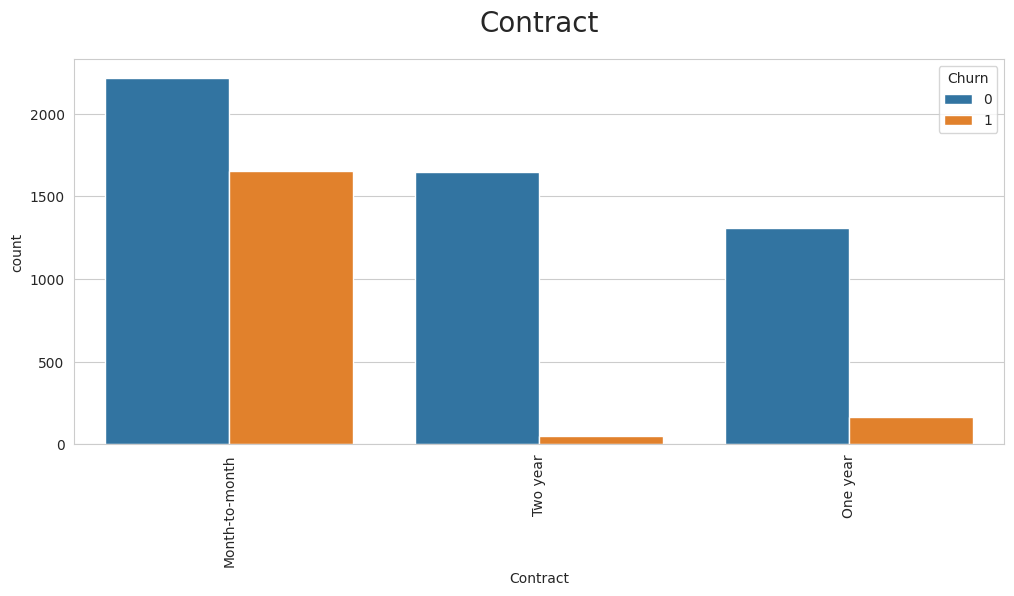

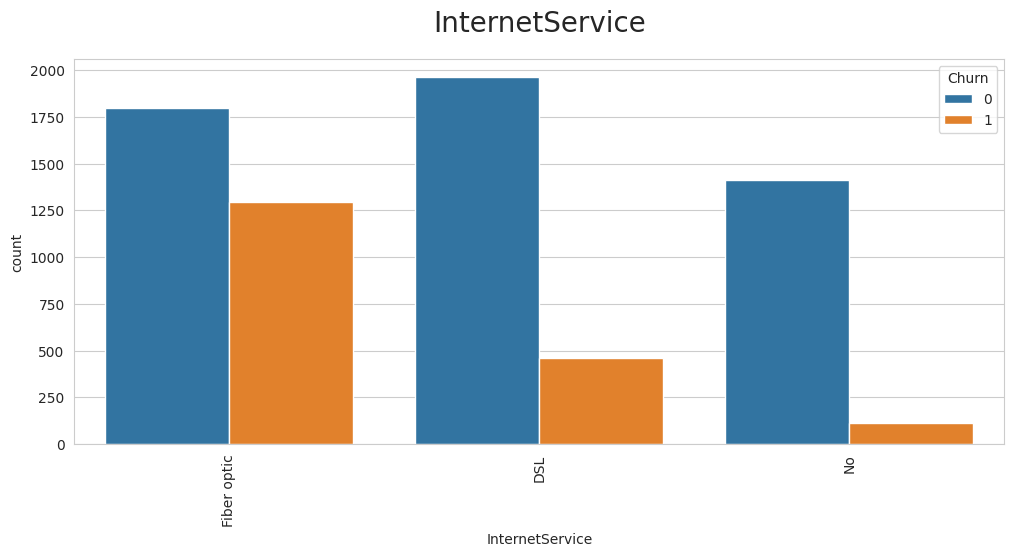

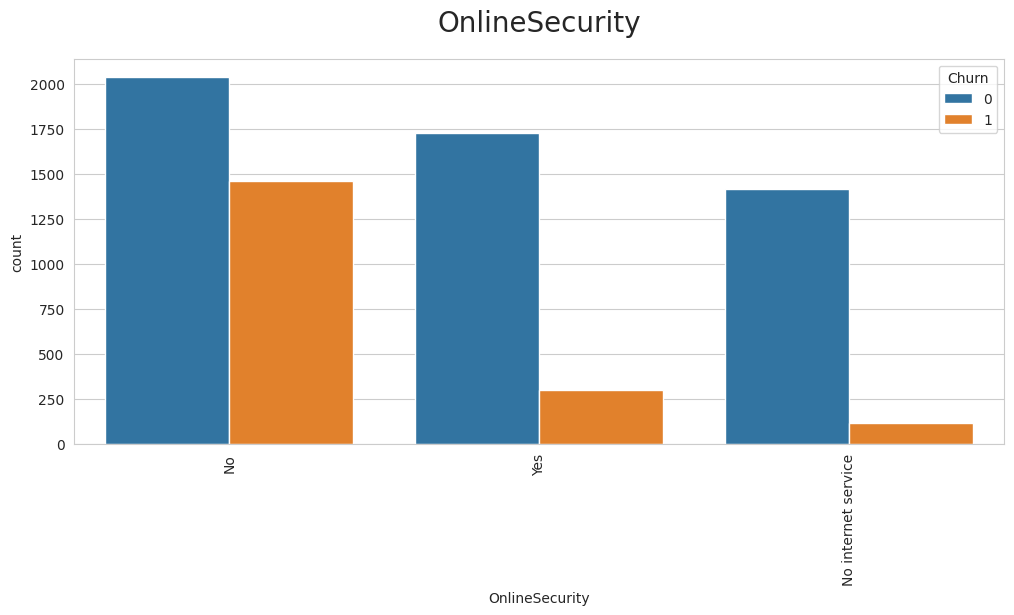

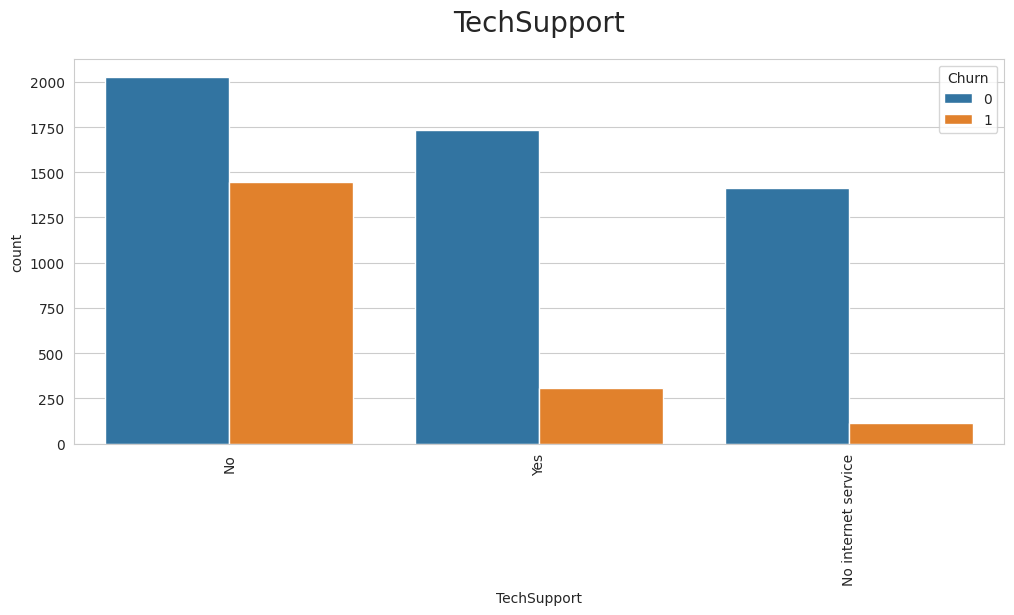

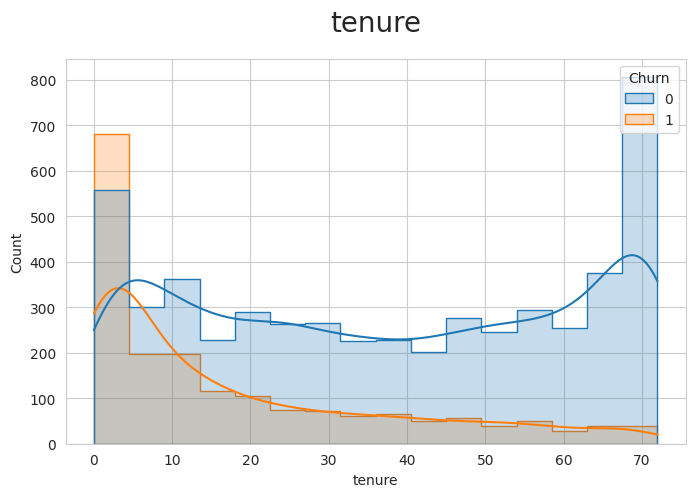

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


def plot_categorical(df, col, target_var):

    plt.figure(figsize=(12, 5))
    sns.countplot(data=df, x=col, hue=target_var, order=df[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


def plot_numerical(df, col, target_var):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, hue=target_var, kde=True, element="step")
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


target_var = 'Churn'
for col in vars_to_study:
    if df_eda[col].dtype == 'object':
        plot_categorical(df_eda, col, target_var)
        print("\n\n")
    else:
        plot_numerical(df_eda, col, target_var)
        print("\n\n")


---

## Parallel Plot

Create a separate DataFrame and transform `tenure` (numerical) into bins (categorical) for visualising at `parallel_categories()` plot


In [15]:
from feature_engine.discretisation import ArbitraryDiscretiser
import numpy as np
tenure_map = [-np.Inf, 6, 12, 18, 24, np.Inf]
disc = ArbitraryDiscretiser(binning_dict={'tenure': tenure_map})
df_parallel = disc.fit_transform(df_eda)
df_parallel.head()

,Contract,InternetService,OnlineSecurity,TechSupport,tenure,Churn
0,Month-to-month,DSL,No,No,0,0
1,One year,DSL,Yes,No,4,0
2,Month-to-month,DSL,Yes,No,0,1
3,One year,DSL,Yes,Yes,4,0
4,Month-to-month,Fiber optic,No,No,0,1


In [16]:
disc.binner_dict_['tenure']

[-inf, 6, 12, 18, 24, inf]

Create a map to replace the `tenure` variable with more informative levels.

In [17]:
n_classes = len(tenure_map) - 1
classes_ranges = disc.binner_dict_['tenure'][1:-1]

labels_map = {}
for n in range(0, n_classes):
    if n == 0:
        labels_map[n] = f"<{classes_ranges[0]}"
    elif n == n_classes-1:
        labels_map[n] = f"+{classes_ranges[-1]}"
    else:
        labels_map[n] = f"{classes_ranges[n-1]} to {classes_ranges[n]}"

labels_map


{0: '<6', 1: '6 to 12', 2: '12 to 18', 3: '18 to 24', 4: '+24'}

Replace using `.replace()`

In [18]:
df_parallel['tenure'] = df_parallel['tenure'].replace(labels_map)
df_parallel.head()

,Contract,InternetService,OnlineSecurity,TechSupport,tenure,Churn
0,Month-to-month,DSL,No,No,<6,0
1,One year,DSL,Yes,No,+24,0
2,Month-to-month,DSL,Yes,No,<6,1
3,One year,DSL,Yes,Yes,+24,0
4,Month-to-month,Fiber optic,No,No,<6,1


Creates multi-dimensional categorical data plot

In [19]:
import plotly.express as px
fig = px.parallel_categories(df_parallel, color="Churn")
fig.show()

---

# Conclusions and Next steps

The correlations and plots interpretation converge. 
* A churned customer typically has a month-to-month contract.
* A churned customer typically has fiber optic.
* A churned customer typically doesn't have tech support.
* A churned customer doesn't have online security.
* A churned customer typically has low tenure levels.

---

Well done! You generated code that answers business requirement 1 and can be used to build Streamlit App
* In this notebook, we are not pushing any file to the repo.
* Clear the cell's outputs before moving on!